In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import json
import os
import imantics
from PIL import Image
from skimage.transform import resize
import random
from sklearn.model_selection import train_test_split
from PIL import Image
from collections import Counter
from scipy.ndimage import label

from sklearn.cluster import KMeans

%matplotlib inline



In [4]:
import os

os.environ['OMP_NUM_THREADS'] = '1'


<a class='anchor' id='visual'></a>
<center>
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#444444;
           font-size:110%;
           font-family:system-ui;
           letter-spacing:0.5px">
    <h1 style = "color:#00ff00; padding:10px;">Dataset<a href="#top" style="color:#00ff00;"> ↑ </a>
    </h1>
    </div>
</center>
    


In [5]:
base_dir = '/kaggle/input/football-player-segmentation'
annote_dir = 'data/instances_default.json'
images_dir = 'data/images' 

In [6]:
image_size = 512
input_image_size = (1920, 1080)

In [7]:
images_listdir = os.listdir(images_dir)


In [8]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    return img

In [9]:
random_images = np.random.choice(images_listdir, size = 9, replace = False)

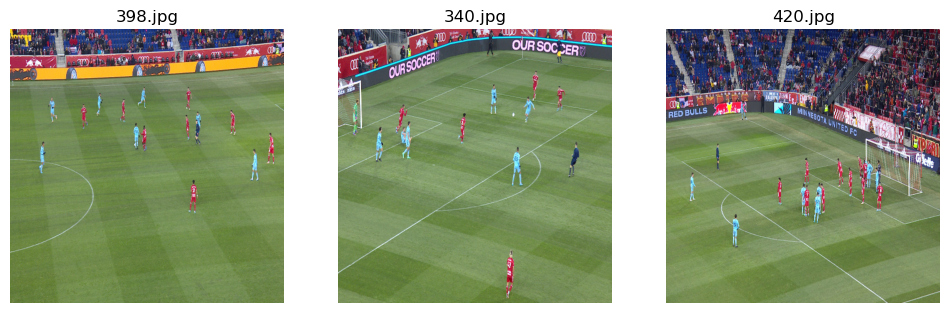

In [10]:
rows = 1
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (12,4))

for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

# Dataset

In [11]:
annote = json.load(open(annote_dir))

In [12]:
id_to_images = {image['id']:image['file_name'] for image in annote['images']}

In [13]:
images = np.zeros((len(images_listdir), image_size, image_size, 3), dtype=np.uint8)

for image_id, image_filename in id_to_images.items():
    cur_image = read_image(f"{images_dir}/{image_filename}")
    images[image_id - 1] = cur_image

In [14]:
masks = np.zeros((len(images_listdir), image_size, image_size, 1), dtype=bool)

for annotation in annote["annotations"]:
    image_id = annotation["image_id"]
    segmentation = annotation["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*input_image_size).array
    cur_mask = np.expand_dims(resize(cur_mask, (image_size, image_size), mode='constant', preserve_range=True), 2)
    # cur_mask = cur_mask.astype(np.uint8) 
    mask_index = image_id - 1
    masks[mask_index] = masks[mask_index] | cur_mask

In [15]:
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.05, random_state=42)



In [16]:
random_numbers = [random.randint(0, 511) for _ in range(9)]

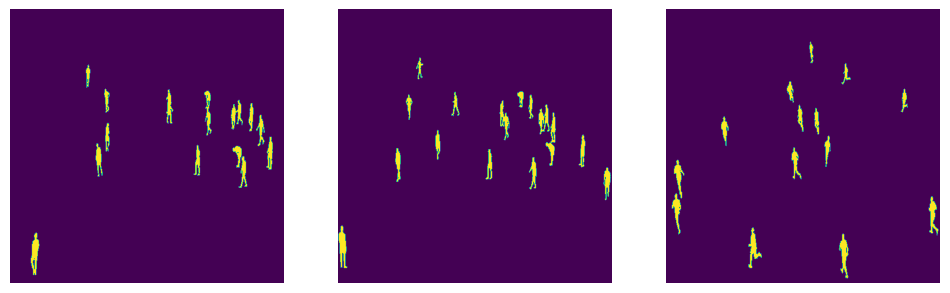

In [17]:
fig, ax = plt.subplots(rows, cols, figsize = (12,8))

for i, ax in enumerate(ax.flat):
    if i < len(random_numbers):
        #ax.imshow(images[i])
        
        ax.imshow(masks[i])#, alpha=0.5)
        ax.axis('off')

In [18]:
mod_masks = []
for i in range(len(masks)):
    temp_mask = np.copy(masks[i])
    temp_mask = temp_mask.astype(np.uint8) 
    temp_mask [temp_mask == 0] = 255
    temp_mask [temp_mask == 1] = 0
    mod_masks.append(temp_mask)

In [23]:
def createMaskedImages(image, mask ):
    # Convert the mask to a binary image using thresholding
    _, binary_mask = cv2.threshold(mask, thresh=1, maxval=255, type=cv2.THRESH_BINARY)

    # Invert the binary mask
    inverted_mask = cv2.bitwise_not(binary_mask)

    # Apply the inverted mask to the original image
    masked_image = cv2.bitwise_and(image, image, mask=inverted_mask)

    # Create a new image with the desired color
    color = (0, 255, 0)  # green color
    colored_image = np.zeros_like(image)
    colored_image[:] = color

    # Replace the black parts of the masked image with the new color
    #result = cv2.bitwise_or(masked_image, colored_image, mask=binary_mask)

    return masked_image
    '''fig, ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))'''


In [24]:
masked_images = []
for i in range(len(masks)):
    temp_mask = np.copy(masks[i])
    temp_mask = mask.astype(np.uint8) 
    temp_mask [temp_mask == 0] = 255
    temp_mask [temp_mask == 1] = 0
    temp_image = np.copy(images[i])
    temp_masked = createMaskedImages(temp_image, temp_mask )
    masked_images.append(temp_masked)
    

In [264]:
mask = np.copy(masks[0])
image = np.copy(images[0])

In [265]:
mask = mask.astype(np.uint8) 

In [266]:
mask [mask == 0] = 255

In [267]:
mask [mask == 1] = 0

In [268]:
masked_image  = createMaskedImages(image, mask )

In [269]:
gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

# test 4

In [32]:

def colorMask(image, target_color, threshold, class_color):
    # Calculate the Euclidean distance between each pixel and the target color
    color_distance = np.linalg.norm(image - target_color, axis=2)

    # Create a mask to filter pixels close to the target color
    color_mask = color_distance < threshold

    # Apply the mask to the original image
    extracted_image = np.zeros_like(image)
    extracted_image[color_mask] = image[color_mask]

    # Assign the class color to each channel of the extracted image
    for i in range(extracted_image.shape[2]):
        extracted_image[..., i][extracted_image[..., i] != 0] = class_color

    return extracted_image

In [33]:
# Define the target color and threshold
team_a_color = np.array([129, 239, 252])  # RGB color (129, 239, 252)
threshold = 60  # Adjust this value to control the color proximity
class_a_color = 230

# Extract blue colors close to the target color
extracted_image = colorMask(masked_image, team_a_color, threshold, class_a_color)

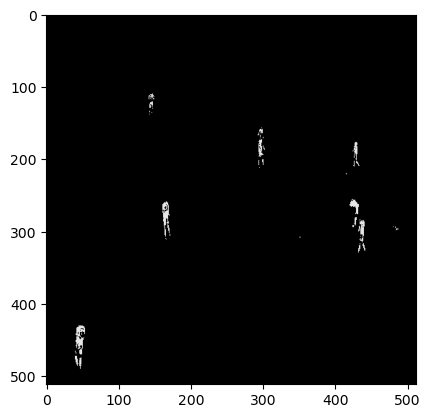

In [34]:

plt.imshow(extracted_image)

In [35]:
newim = extracted_image+mask

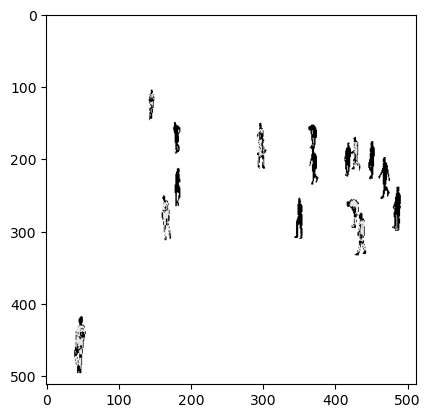

In [36]:
plt.imshow(newim)

In [114]:
def recolor_black_pixels_to_red(image):
    red = [255, 0, 0]  # Red color in RGB format

    # Create a mask for black pixels
    black_pixels_mask = np.all(image == [0, 0, 0], axis=2)

    # Apply red color to the black pixels
    image[black_pixels_mask] = red

    return image
#====================================
def recolor_black_pixels_to_red_and_white_pixels_to_black(image):
    red = [10, 10, 10]  # Red color in RGB format
    black = [0, 0, 0]  # Black color in RGB format

    # Create a mask for black pixels
    black_pixels_mask = np.all(image == black, axis=2)

    # Create a mask for white pixels
    white_pixels_mask = np.all(image == [255, 255, 255], axis=2)

    # Apply red color to the black pixels
    image[black_pixels_mask] = red

    # Apply black color to the white pixels
    image[white_pixels_mask] = black

    return image

In [115]:
redimg = recolor_black_pixels_to_red_and_white_pixels_to_black(newim.copy())

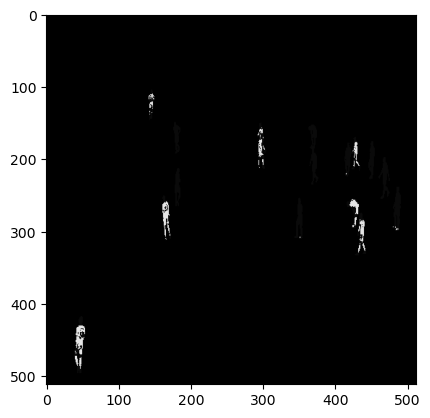

In [116]:
plt.imshow(redimg)

In [171]:
def color_most_frequent_regions2(image, team_color):
    # Find connected regions
    labels, num_features = label(np.any(image != 0, axis=-1))
    # Loop through each connected region
    for i in range(1, num_features + 1):
        # Get the region mask
        mask = (labels == i)

        # Get the colors in the region
        region_colors = image[mask]
       
        flat_array = region_colors.flatten()
        #print(flat_array)
        vals, counts = np.unique(flat_array, return_counts=True)
        # print the value and its frequecy
        for val, count in zip(vals, counts):
            #print(f'{val} occurs {count} times')
            if val == team_color  and count > 150:
                #print("team a")
                image[mask] = team_color
            elif (val == team_color  and count < 150) or len(vals) == 1:
                image[mask] = 0
                #print("team b")
        # If the region is not empty, color it with the most frequent color
        '''if len(region_colors) > 0:
            most_frequent_color = np.bincount(region_colors.reshape(-1, 3).argmax(axis=1)).argmax()
            image[mask] = region_colors[most_frequent_color]'''
        

    return image

In [157]:
mostfeq = color_most_frequent_regions2(redimg.copy(),230)

10 occurs 429 times
230 occurs 195 times
team a
-----------------------------
10 occurs 741 times
team b
-----------------------------
10 occurs 765 times
230 occurs 474 times
team a
-----------------------------
10 occurs 1533 times
team b
-----------------------------
10 occurs 1275 times
230 occurs 321 times
team a
-----------------------------
10 occurs 882 times
team b
-----------------------------
10 occurs 1116 times
team b
-----------------------------
10 occurs 855 times
team b
-----------------------------
10 occurs 1287 times
230 occurs 27 times
team b
-----------------------------
10 occurs 546 times
230 occurs 750 times
team a
-----------------------------
10 occurs 1068 times
230 occurs 6 times
team b
-----------------------------
10 occurs 492 times
230 occurs 468 times
team a
-----------------------------
10 occurs 645 times
230 occurs 537 times
team a
-----------------------------
10 occurs 1080 times
230 occurs 1062 times
team a
-----------------------------


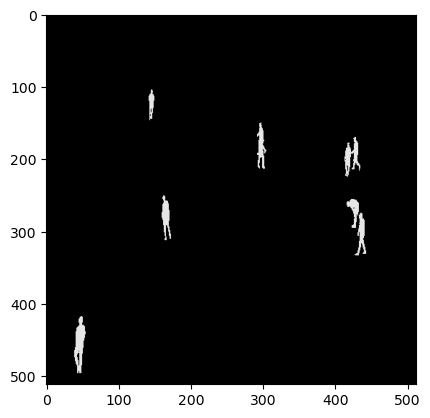

In [158]:
plt.imshow(mostfeq)

# Team B

In [163]:
# Define the target color and threshold
team_b_color = np.array([170, 25, 50]) 
threshold_b = 60  # Adjust this value to control the color proximity
class_b_color = 180

# Extract blue colors close to the target color
extracted_imageB = colorMask(masked_image, team_b_color, threshold_b, class_b_color)

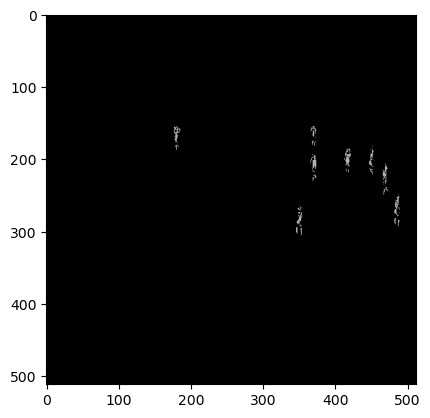

In [164]:
plt.imshow(extracted_imageB)

In [165]:
newim_b = extracted_imageB+mask

In [166]:
redimg_b = recolor_black_pixels_to_red_and_white_pixels_to_black(newim_b.copy())

In [167]:
mostfeq_b = color_most_frequent_regions2(redimg_b.copy(), 180)

10 occurs 624 times
team b
-----------------------------
0 occurs 2 times
10 occurs 465 times
180 occurs 274 times
team a
-----------------------------
10 occurs 1239 times
team b
-----------------------------
0 occurs 1 times
10 occurs 1062 times
180 occurs 470 times
team a
-----------------------------
0 occurs 1 times
10 occurs 1269 times
180 occurs 326 times
team a
-----------------------------
0 occurs 1 times
10 occurs 663 times
180 occurs 218 times
team a
-----------------------------
10 occurs 828 times
180 occurs 288 times
team a
-----------------------------
10 occurs 855 times
team b
-----------------------------
10 occurs 990 times
180 occurs 324 times
team a
-----------------------------
10 occurs 1296 times
team b
-----------------------------
10 occurs 771 times
180 occurs 303 times
team a
-----------------------------
10 occurs 960 times
team b
-----------------------------
10 occurs 1182 times
team b
-----------------------------
10 occurs 2142 times
team b
-----------

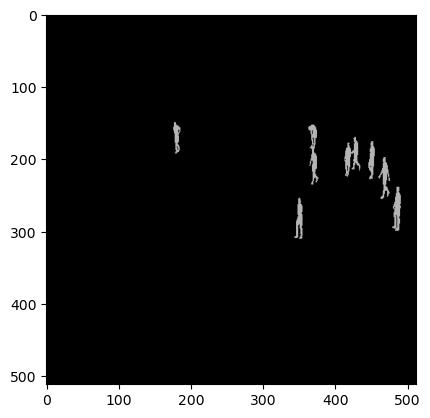

In [168]:
plt.imshow(mostfeq_b)

In [169]:
mask2 = mostfeq_b+mostfeq

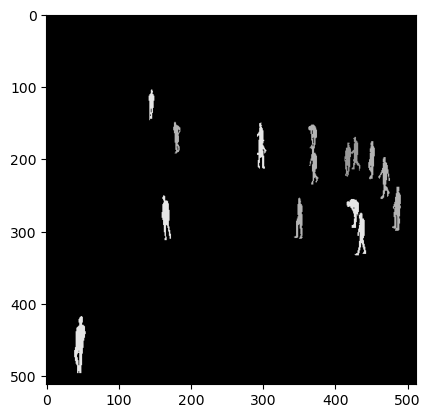

In [170]:
plt.imshow(mask2)

# Referee

In [177]:
# Define the target color and threshold
ref_color = np.array([30, 50, 90])  # RGB color (129, 239, 252)
threshold_ref = 30  # Adjust this value to control the color proximity
class_ref_color = 50

# Extract blue colors close to the target color
extracted_image_ref = colorMask(masked_image, ref_color, threshold_ref, class_ref_color)

In [178]:
newim_ref = extracted_image_ref+mask

In [179]:
redimg_ref = recolor_black_pixels_to_red_and_white_pixels_to_black(newim_ref.copy())

In [180]:
mostfeq_ref = color_most_frequent_regions2(redimg_ref.copy(), 50)

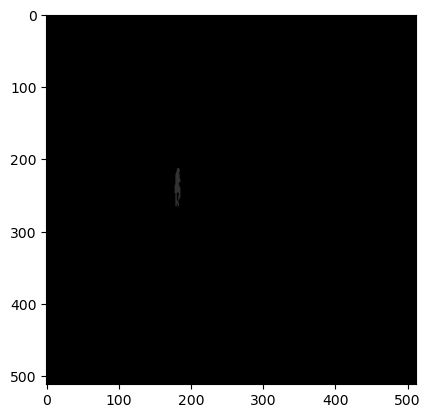

In [181]:
plt.imshow(mostfeq_ref)

# GoalKeeper 1

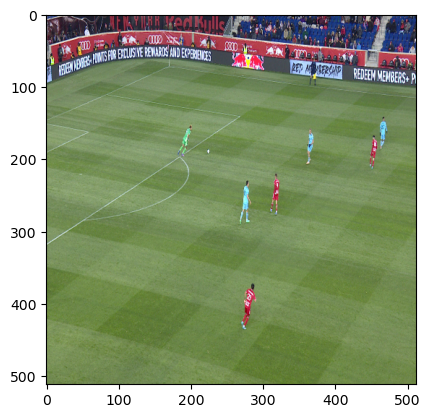

In [403]:
plt.imshow(images[200])

In [387]:
maskgk1 = np.copy(masks[200])
imagegk1 = np.copy(images[200])

In [388]:
maskgk1 = maskgk1.astype(np.uint8) 

In [389]:
maskgk1 [maskgk1 == 0] = 255

In [390]:
maskgk1 [maskgk1 == 1] = 0

In [391]:
maskedgk1_image  = createMaskedImages(imagegk1, maskgk1 )

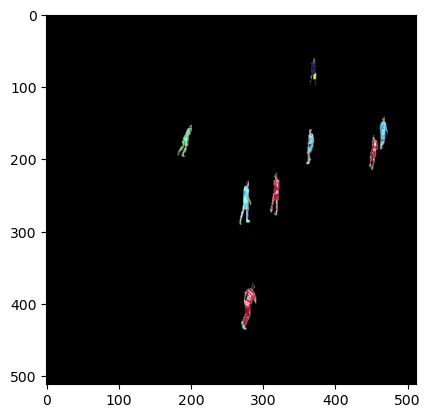

In [392]:
plt.imshow(maskedgk1_image)

In [398]:
# Define the target color and threshold
goalkeeper1_color = np.array([110, 220, 150])  
threshold_goalkeeper1 = 50  
class_goalkeeper1_color = 160

extracted_image_goalkeeper1 = colorMask(maskedgk1_image, goalkeeper1_color, threshold_goalkeeper1, class_goalkeeper1_color)

In [399]:
newim_gk1 = extracted_image_goalkeeper1+maskgk1

In [400]:
redimg_gk1 = recolor_black_pixels_to_red_and_white_pixels_to_black(newim_gk1.copy())

In [401]:
mostfeq_gk1 = color_most_frequent_regions2(redimg_gk1.copy(), 160)

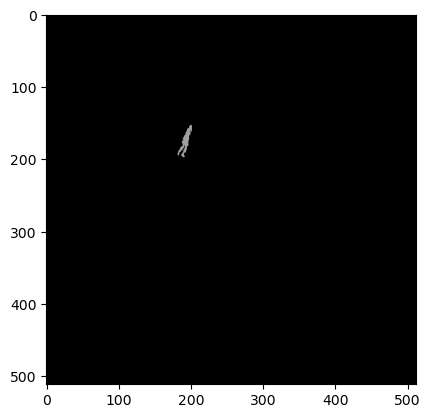

In [402]:
plt.imshow(mostfeq_gk1)

# GoalKeeper 2

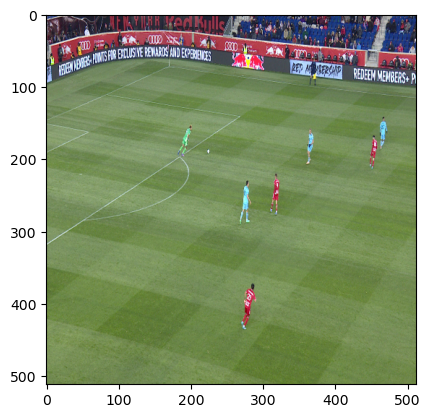

In [403]:
plt.imshow(images[200])

In [387]:
maskgk1 = np.copy(masks[200])
imagegk1 = np.copy(images[200])

In [388]:
maskgk1 = maskgk1.astype(np.uint8) 

In [389]:
maskgk1 [maskgk1 == 0] = 255

In [390]:
maskgk1 [maskgk1 == 1] = 0

In [391]:
maskedgk1_image  = createMaskedImages(imagegk1, maskgk1 )

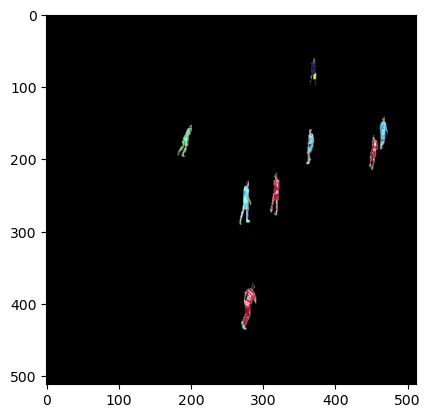

In [392]:
plt.imshow(maskedgk1_image)

In [398]:
# Define the target color and threshold
goalkeeper1_color = np.array([110, 220, 150])  
threshold_goalkeeper1 = 50  
class_goalkeeper1_color = 160

extracted_image_goalkeeper1 = colorMask(maskedgk1_image, goalkeeper1_color, threshold_goalkeeper1, class_goalkeeper1_color)

In [399]:
newim_gk1 = extracted_image_goalkeeper1+maskgk1

In [400]:
redimg_gk1 = recolor_black_pixels_to_red_and_white_pixels_to_black(newim_gk1.copy())

In [401]:
mostfeq_gk1 = color_most_frequent_regions2(redimg_gk1.copy(), 160)

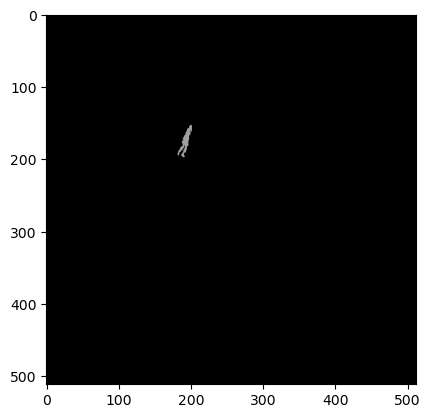

In [402]:
plt.imshow(mostfeq_gk1)

========================================================

### Failed Atttempts

## Clustering 

In [169]:
import numpy as np
import cv2

def extract_color_histogram(image):
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Calculate the histogram of the Hue channel
    histogram = cv2.calcHist([hsv_image], [0], None, [180], [0, 180])
    
    # Normalize the histogram
    histogram = cv2.normalize(histogram, histogram).flatten()
    
    return histogram

def classify_objects(image, mask):
    object_classes = []
    
    # Convert the mask to binary (if not already)
    #_, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
    binary_mask = mask
    # Find contours of objects in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        # Create a bounding rectangle around the contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Extract the object from the image using the bounding rectangle
        object_image = image[y:y+h, x:x+w]
        
        # Extract the color histogram of the object
        histogram = extract_color_histogram(object_image)
        
        # Store the histogram, coordinates, and label in the object_classes list
        object_classes.append({"histogram": histogram, "coords": (x, y, x+w, y+h), "label": None})
    
    return object_classes

def draw_bounding_boxes(image, object_classes, class_labels):
    print(len(object_classes))
    for obj in object_classes:
        coords = obj["coords"]
        label = class_labels[obj["label"]]
        
        # Draw the bounding box on the image
        cv2.rectangle(image, (coords[0], coords[1]), (coords[2], coords[3]), (0, 255, 0), 2)
        
        # Add the class label as text on the image
        cv2.putText(image, label, (coords[0], coords[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return image

# Classify the objects in the image based on their color histograms
object_classes = classify_objects(image2, mask2)

# Define the class labels
class_labels = {
    0: " A",
    1: "B"
    # Add more class labels if needed
}

# Assign labels to the object classes
for i, obj in enumerate(object_classes):
    # You can replace this with your own logic to assign labels based on your classification method
    obj["label"] = i % len(class_labels)

# Draw bounding boxes and labels on the original image
output_image = draw_bounding_boxes(image2.copy(), object_classes, class_labels)


14


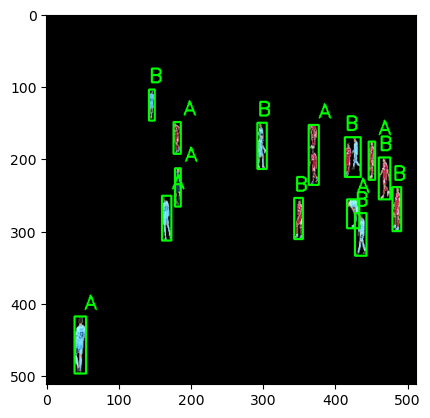

In [170]:
plt.imshow(output_image)

# recoloring test1


In [77]:
def color_most_frequent_regions(image):
    # Find connected regions
    labels, num_features = label(np.any(image != 0, axis=-1))

    # Loop through each connected region
    for i in range(1, num_features + 1):
        # Get the region mask
        mask = (labels == i)

        # Get the colors in the region
        region_colors = image[mask]

        # If the region is not empty, color it with the most frequent color
        if len(region_colors) > 0:
            most_frequent_color = np.bincount(region_colors.reshape(-1, 3).argmax(axis=1)).argmax()
            image[mask] = region_colors[most_frequent_color]

    return image

In [78]:
new_image = color_most_frequent_regions(np.copy(masked_image))

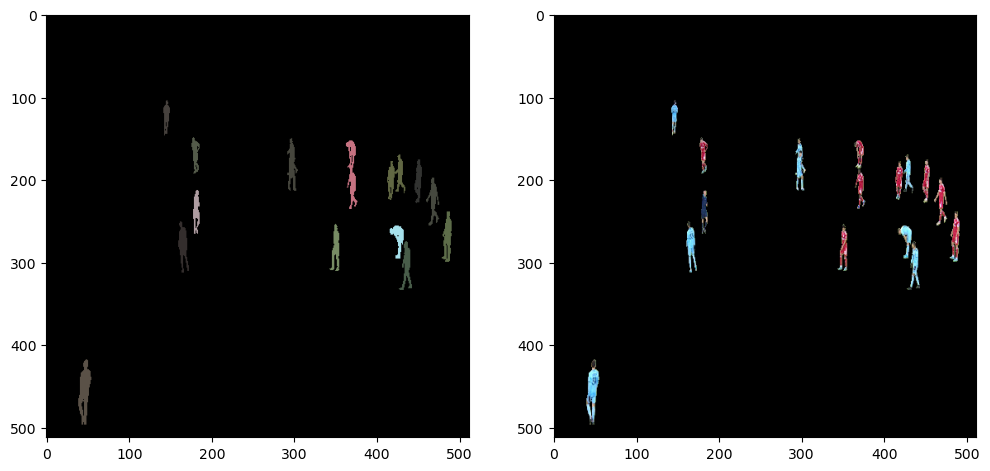

In [79]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(new_image)
ax[1].imshow(masked_image)